In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from   torch.autograd import Variable

### Dataloader and ImageProcesser

In [3]:
from visualization import *
from image_process import*
from dataload import *
train_path="/media/tianning/DATA/VOT/VOT2018"
dataloader=MyDataLoader(train_path)
imgprocesser=data_process(128,256)
#xes,yes,zes,tes=get_batch_input(dataloader,imgprocesser,1,True)

### KCF implement

In [4]:
from model_utils import *

In [15]:
dataloader.isfix_frame=True
dataloader.fixed_frame=10

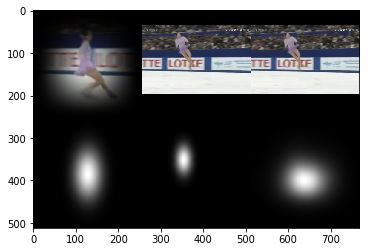

In [22]:
imgp=imgprocesser
xes,yes,zes,tes=get_batch_input(dataloader,imgprocesser,1,True)
self_entangle = entangle_gauss(xes,xes)
cros_entangle = entangle_gauss(zes,xes)

final_phase_y = fullfft(yes)

B,C,W,H = self_entangle.shape
final_phase_x = fullfft(self_entangle)
final_phase_z = cros_entangle

alphaf = complex_div(final_phase_y,final_phase_x+0.001)

alpha  = torch.irfft(alphaf,2,onesided=False)
final_phase_o=entangle_tensor(final_phase_z,alpha,'fft','nn',sum_channel=1)
response=final_phase_o[0,0].cpu().numpy()
response-= response.min()
response/= response.max()
v_centre, h_centre = np.unravel_index(response.argmax(), response.shape)
vert_delta, horiz_delta = [v_centre - response.shape[0] / 2,
                           h_centre - response.shape[1] / 2]
vert_delta /=imgp.scale_z
horiz_delta/=imgp.scale_z
t=tes[0,0].cpu().numpy()
y=yes[0,0].cpu().numpy()
r=response
a=cv2.resize(imgp.template_patch_win,(256,256))
b=imgp.detected_patch
c=cv2.merge([t,t,t])
d=cv2.merge([r,r,r])
y=cv2.merge([y,y,y])
y=cv2.resize(y,(256,256))
temp1= np.concatenate([a,b,b],1)
temp2= np.concatenate([y,c,d],1)
rgb_print(np.concatenate([temp1,temp2]))

althogh the different shape between x and z do not block the convolution calculation. The performance get really influence.
YOU can see, even in same picture, the performance can not get good.

### MLKFT Layer

##### define

In [3]:
from models import TransposeBottleneckV1,PositiveBottleneckV1,UPDownLayer

from model_utils import *

class MLKCF(nn.Module):
    def __init__(self,inchan,midchan,outchan,resize,layers_num):
        super(MLKCF,self).__init__()
        self.entangle_fex = entangle_xz
        UP_block          = TransposeBottleneckV1
        Down_block        = PositiveBottleneckV1
        self.Down_Layer   = UPDownLayer(inchan,midchan,resize,layers_num=layers_num,block=Down_block)
        self.Up_Layer     = UPDownLayer(midchan,outchan,resize,layers_num=layers_num,block=UP_block)

        self.debug = False
        self.mseloss=nn.MSELoss()
        self.KLloss =nn.KLDivLoss(reduction='mean')
    
    def forward(self, _input,target=None):
        """ The input should be of size [batch_size, 3, img_h, img_w] """
        detected_img,template_img,template_y = _input
        
        self_entangle_fea = self.entangle_fex(template_img,template_img)#B,5,w,h
        cros_entangle_fea = self.entangle_fex(detected_img,template_img)#B,5,W,H

        self_entangle     = self.Up_Layer(self.Down_Layer(self_entangle_fea))#B,C,w,h
        cros_entangle     = self.Up_Layer(self.Down_Layer(cros_entangle_fea))#B,C,W,H

        final_phase_y   = fullfft(template_y)   #B,1,w,h,2
        final_phase_kxx = fullfft(self_entangle)#B,C,w,h,2
        _lambda = 0
        alphaf = complex_div(final_phase_y,final_phase_kxx+_lambda)#B,C,w,h,2
        
        alpha       = torch.irfft(alphaf,2,onesided=False)#B,C,w,h
        kernel_zx   = cros_entangle                       #B,C,W,H
        output=entangle_tensor(kernel_zx,alpha,'fft','nn',sum_channel=1)#B,1,W,H
#         _min = output.min()
#         _max = output.max()
#         response = (output-_min)/(_max-_min)
        response = torch.sigmoid(output)#B,1,W,H
#        response = output

        if self.debug:
            self.self_entangle_fea=self_entangle_fea
            self.cros_entangle_fea=cros_entangle_fea
            self.self_entangle    =self_entangle    
            self.cros_entangle    =cros_entangle    
            self.final_phase_y    =final_phase_y    
            self.final_phase_kxx  =final_phase_kxx
            self.alphaf           =alphaf
            self.alpha            =alpha    
            self.kernel_zx        =kernel_zx
            self.output           =output
            
        if target is None:
            out=response
        else:
            #target #B,1,W,H
            #loss = self.KLloss(final_phase_o.log(),final_phase_t,)
            loss = self.mseloss(response ,target)
            out=loss

        return out

##### test

In [4]:
model=MLKCF(5,32,32,4,3)
_=model.cuda()

In [32]:
i=0
for name,p in model.named_parameters():
    print("{:40} {:5} {}".format(name,np.prod(p.shape),p.shape))
    i+=np.prod(p.shape)
print(i)

Down_Layer.net.0_X2.conv1.weight            45 torch.Size([9, 5, 1, 1])
Down_Layer.net.0_X2.bn1.weight               9 torch.Size([9])
Down_Layer.net.0_X2.bn1.bias                 9 torch.Size([9])
Down_Layer.net.0_X2.conv2.weight           729 torch.Size([9, 9, 3, 3])
Down_Layer.net.0_X2.bn2.weight               9 torch.Size([9])
Down_Layer.net.0_X2.bn2.bias                 9 torch.Size([9])
Down_Layer.net.0_X2.conv3.weight           126 torch.Size([14, 9, 1, 1])
Down_Layer.net.0_X2.bn3.weight              14 torch.Size([14])
Down_Layer.net.0_X2.bn3.bias                14 torch.Size([14])
Down_Layer.net.0_X2.downsample.0.weight    630 torch.Size([14, 5, 3, 3])
Down_Layer.net.0_X2.downsample.1.weight     14 torch.Size([14])
Down_Layer.net.0_X2.downsample.1.bias       14 torch.Size([14])
Down_Layer.net.1_X2.conv1.weight           252 torch.Size([18, 14, 1, 1])
Down_Layer.net.1_X2.bn1.weight              18 torch.Size([18])
Down_Layer.net.1_X2.bn1.bias                18 torch.Size([18])


### DMLKCF

#### define

In [3]:
def generate_dense_dis(tensor,d_w,d_h):
    '''
    tensor(B,1,4) s_x,s_y,s_w,s_h per batch
    target_x=s_x*w
    target_y=s_y*h
    target_w=s_w*w
    target_h=s_h*h
    '''
    yes=[]
    for batch in tensor:
        s_x,s_y,s_w,s_h = batch[0]
        c_x=s_x*d_w
        c_y=s_y*d_h
        c_w=s_w*d_w
        c_h=s_h*d_h
        g_x=d_w
        g_y=d_h
        grid_x  = torch.arange(g_x,dtype=tensor.dtype)
        grid_y  = torch.arange(g_y,dtype=tensor.dtype)
        rs, cs  = torch.meshgrid(grid_x, grid_y)
        sigmaw  = c_w/np.sqrt(2*np.log(10000))
        sigmah  = c_h/np.sqrt(2*np.log(10000))
        y = torch.exp(-0.5*((1.0*(rs-c_x)/sigmaw)**2+(1.0*(cs-c_y)/sigmah)**2))
        yes.append(y[None])
    out=torch.stack(yes)
    if tensor.is_cuda:
        return out.cuda()
    return out

In [4]:
from model_utils import *
class DMLKCF(nn.Module):

    def __init__(self,cfg):
        super(DMLKCF,self).__init__()
        backbone_config= cfg.backbone
        fpn_config     = cfg.fpn
        self.body      = BodyLayer(backbone_config,fpn_config)
        self.entangle  = entangle_gauss
        self.mseloss   = nn.MSELoss()
        
    def forward(self, _input,target=None):
        """ The input should be of size [batch_size, 3, img_h, img_w] """
        detected_img,template_img,information_y = _input
        #information_y #B,4 # the s_x,s_y,s_w,s_h per batch
        template_feas  = self.body(template_img)
        detected_feas  = self.body(detected_img)
        response_list  = []
        for template_fea,detected_fea in zip(template_feas,detected_feas):
            B,C,w,h        = template_fea.shape
            yes_for_now_dim= generate_dense_dis(information_y,w,h) #B,1,w_n,h_n
            self_entangle  = self.entangle(template_fea,template_fea)#B,C,w_n,h_n
            cros_entangle  = self.entangle(detected_fea,detected_fea)#B,C,W_n,H_n
            final_phase_y  = fullfft(yes_for_now_dim)#B,1,w_n,h_n,2
            final_phase_x  = fullfft(self_entangle)  #B,C,w_n,h_n,2
            final_phase_z  = cros_entangle           #B,3,W_n,H_n
            alphaf         = complex_div(final_phase_y,final_phase_x) #B,C,w_n,h_n,2
            alpha          = torch.irfft(alphaf,2,onesided=False)     #B,C,w_n,h_n
            final_phase_o  = entangle_tensor(final_phase_z,alpha,'fft','nn',sum_channel=1)#B,1,W_n,H_n
            response       = torch.sigmoid(final_phase_o)#B,1,W_n,H_n
            response_list.append(response)

        if target is None:
            return response_list
        else:
            #target #B,4 # the s_x,s_y,s_w,s_h per batch
            losses=0
            for response in response_list:
                B,C,W,H        = response.shape #B,1,W_n,H_n
                tes_for_now_dim= generate_dense_dis(target,W,H) #B,1,W_n,H_n
                loss = self.mseloss(response ,tes_for_now_dim)
                losses+=loss
            return losses

#### test

In [5]:
from backbone import *
from config import *
backbone_config = resnet50_backbone
backbone_config.selected_layers=[0,1,2]
fpn_config      = fpn_base
#body            = BodyLayer(backbone_config,fpn_config)

In [ ]:
del model
torch.cuda.empty_cache()

In [7]:
cfg=Config({
    'backbone':resnet50_backbone,
    'fpn':fpn_base
})
model=DMLKCF(cfg)
_=model.cuda()

In [61]:
xes,yes,zes,tes=get_batch_input(dataloader,imgprocesser,5,True)

In [15]:
from universal_model_util import *

In [29]:
get_model_para_detail(model,mode='graded')

body.backbone.layers.0.0.conv1.weight     4096 torch.Size([64, 64, 1, 1])
body.backbone.layers.0.0.bn1.weight         64 torch.Size([64])
body.backbone.layers.0.0.bn1.bias           64 torch.Size([64])
body.backbone.layers.0.0.conv2.weight    36864 torch.Size([64, 64, 3, 3])
body.backbone.layers.0.0.bn2.weight         64 torch.Size([64])
body.backbone.layers.0.0.bn2.bias           64 torch.Size([64])
body.backbone.layers.0.0.conv3.weight    16384 torch.Size([256, 64, 1, 1])
body.backbone.layers.0.0.bn3.weight        256 torch.Size([256])
body.backbone.layers.0.0.bn3.bias          256 torch.Size([256])
body.backbone.layers.0.0.downsample.0.weight 16384 torch.Size([256, 64, 1, 1])
body.backbone.layers.0.0.downsample.1.weight   256 torch.Size([256])
body.backbone.layers.0.0.downsample.1.bias   256 torch.Size([256])
body.backbone.layers.0.1.conv1.weight    16384 torch.Size([64, 256, 1, 1])
body.backbone.layers.0.1.bn1.weight         64 torch.Size([64])
body.backbone.layers.0.1.bn1.bias    

In [13]:
model.body

BodyLayer(
  (backbone): ResNetBackbone(
    (layers): ModuleList(
      (0): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (1): Bottleneck(
          (conv1): Conv2d(256, 64, kerne

### Train Moduler

In [8]:
##config the dataset and pre-process
dataloader=MyDataLoader(train_path)
dataloader.one_class=True
dataloader.set_one_class('/media/tianning/DATA/VOT/VOT2018/bag')
dataloader.isfix_frame=True
dataloader.fixed_frame=1
dataloader.delta_frame=dataloader.fixed_frame
imgp=imgprocesser=data_process(128,256)
imgp.hanning_for_detected = False
#imgp.distribution = 'normal'
imgp.distribution = 'ratio_form'

In [9]:
# set the logging handle
import sys
from fastprogress import master_bar, progress_bar
from train_utils import AverageMeter,RecordLoss,adjust_learning_rate
losses  = AverageMeter()
log_hand= RecordLoss([losses],[[]],100)

In [10]:
epoches   = 10
batches   = 10000
batch     = 10
lr        = 0.0001
momentum  = 0.9
decay     = 0.0001
mb = master_bar(range(epoches))
cur_lr=lr
cuda=True
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.01,weight_decay=0.01)

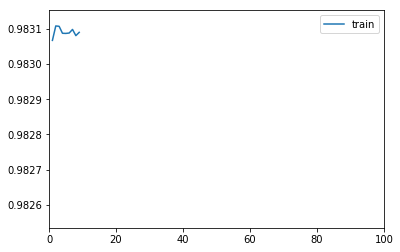

KeyboardInterrupt: 

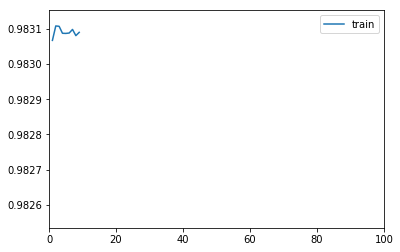

In [11]:
## train head
steps=0
for epoch in mb:
    cur_lr = adjust_learning_rate(cur_lr, optimizer, epoch, gamma=0.1)
    for iters in progress_bar(range(batches), parent=mb):
        xes,yes,zes,tes=get_batch_input(dataloader,imgprocesser,batch,cuda)
        #xes,yes,zes,tes=xess,yess,zess,tess
        loss = model([zes,xes,yes],tes)
        if torch.isnan(loss):sys.exit(0)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        log_hand.step(steps,[loss])
        log_hand.update_graph(mb,steps)
        print("epoch:{:3}/{}  batch:{:3}/{} loss:{:.4f}".format(epoch,epoches,iters,batches,loss.cpu().item()), end="\r")
        
        steps += 1
        
        if steps%100==1:
            log_hand.print2file(steps,"loss.log")
            
        if (steps+1) % 2000 == 0:
            file_path = os.path.join('weights', 'weights-{:07d}.pth.tar'.format(steps))
            model.save_weights(file_path)

            
file_path = os.path.join('weights', 'weights-{:07d}.pth.tar'.format(steps))
model.save_weights(file_path)